In [6]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import cv2
import time
import random
from moviepy.editor import VideoFileClip

#### Load Test Images

In [7]:
def display_images(images,rows,columns,text=[],axis="off"):
    fig = plt.figure(figsize=(30, 20))
    for i in enumerate(images):
        # Adds a subplot at the 1st position
        fig.add_subplot(rows, columns, i[0]+1)
        # showing image
        plt.imshow(i[1])
        plt.axis(axis)
        try:
            plt.title(text[i[0]])
        except:
            if(i[0]<1):
                print("No text input")
    pass

No text input


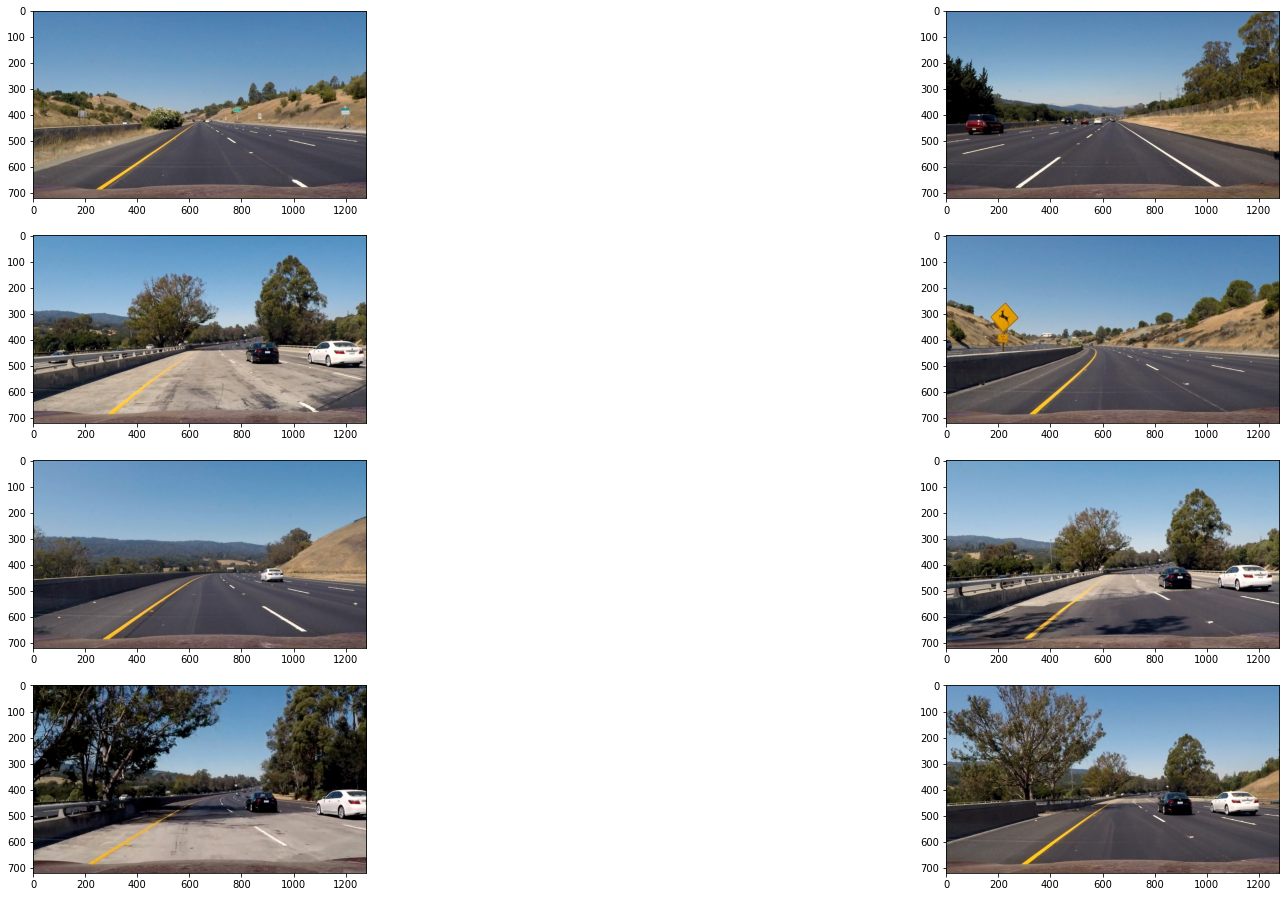

In [8]:
test_images = np.array([plt.imread(i) for i in glob.glob('../test_images/*.jpg')])
display_images(test_images,len(test_images)//2 + 1,2,axis="on")
# display_images(test_images,3,2,axis="on")
    

#### Neural Network Setup

In [9]:
# Load yolo config and weights file
weights_path ="yolov3.weights"
config_path = "yolov3.cfg"
print("Loaded Yolo weights and config ")
# Load Neural Net
net = cv2.dnn.readNetFromDarknet(config_path,weights_path) # Create neural network Yolo V3
# Get layer names 
names = net.getLayerNames() # Gets names for all Yolo layers
# Predication happen at layers 82 94 106
layers_names = [names[i - 1] for i in net.getUnconnectedOutLayers()] # Gets those unconnected layers i.e 82,94,106
print(layers_names)

Loaded Yolo weights and config 
['yolo_82', 'yolo_94', 'yolo_106']


#### Read Coco file for labels

In [10]:
labels_path = "coco.names"
labels = open(labels_path).read().strip().split("\n")
print("Labels loaded successfully...")

Labels loaded successfully...


#### Output image pipeline

In [11]:
def detect_cars_image(img):
    #Input for neural network is called blob object
    #cv.dnn.blobFromImage(img, scale, size, mean)
    (H,W,_) = img.shape
    img = np.copy(img)
    blob = cv2.dnn.blobFromImage(img,
                             1/255.0, #Normalize pixels to 0 and 1
                             (416,416), 
                             crop=False, 
                             swapRB=False 
                            )
    #A blob is a 4D numpy array object (images, channels, width, height)
    #Blob object is sent as an input to network
    net.setInput(blob)
    
    #start_t = time.time()
    
    #forward path to prediction layers
    layers_output = net.forward(layers_names) #The outputs object are vectors of lenght 85
    
    '''
    4x the bounding box (centerx, centery, width, height)
    1x box confidence
    80x class confidence
    '''
    
    #print("A forward path through yolov3 took {} Seconds".format(time.time()-start_t))
    
    boxes = [] # Boxes to draw points of a rectangle diagonal
    confidences = [] # returns percentage of confidence for each box
    classIDs = [] # returns the id of each class
    for output in layers_output: #loop over all detected objects
        for detection in output: #loop over 
            # Storing info about detected object
            scores= detection[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]
            
            if confidence > 0.85:
                #detection[:4] returns centerx,y and w,h that are percentage of real H,W
                box = detection[:4] * np.array([W,H,W,H]) # Scalar product
                bx, by, bw, bh = box.astype("int")


                x = int(bx-(bw/2)) #Since bx and by are not actually the center of the image
                y = int(by-(bh/2))

                boxes.append([x, y, int(bw), int(bh)])
                confidences.append(confidence)
                classIDs.append(classID)
    
    idxs = cv2.dnn.NMSBoxes(boxes,confidences,0.8,0.4) #returns array of idxs of good boxes
    # IOU = 0.4 to remove overlapping boxes with 40% with the highest score box
#     print(idxs)
  
    #Box drawing
    if(len(idxs)> 0):
        for i in idxs: # Why idxs.flatten()?
            (x,y) = [boxes[i][0], boxes[i][1]]
            (w,h) = [boxes[i][2], boxes[i][3]]
#             r = random.randint(0,255)
#             g = random.randint(0,255)
#             b = random.randint(0,255)
            color = (255,20,147)
            cv2.rectangle(img,(x,y),(x+w,y+h),color,2)
            cv2.putText(img,"{}: {:.4f}".format(labels[classIDs[i]],
                                                confidences[i]) ,(x, y - 5),
                                                 cv2.FONT_HERSHEY_SIMPLEX,
                                                 0.5,
                                                 color,
                                                 2)
        
            
    return img

In [16]:
tstart = time.time()
result = detect_cars_image(test_images[random(0,len(test_images))])
plt.imshow(result)
print("Time taken is: {}".format(time.time()-tstart))

NameError: name 'random' is not defined

No text input


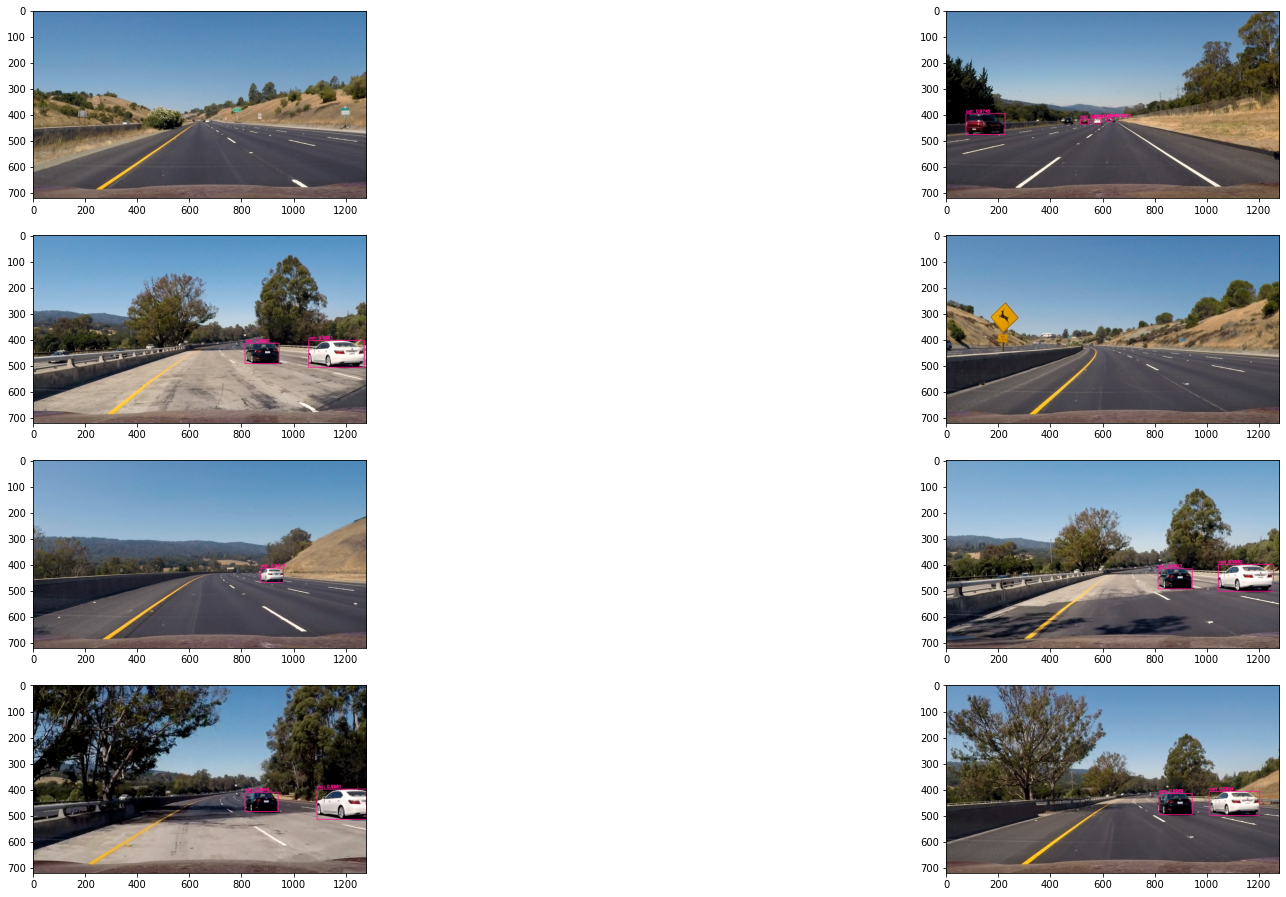

In [13]:
result = [detect_cars_image(image) for image in test_images]
display_images(result,len(result)//2+1,2,axis="on")


#### Output Video

In [ ]:
project_video_res = '../output_videos/YOLO/project_video_result.mp4'
clip1 = VideoFileClip("../test_videos/project_video_30.mp4")
project_video_clip = clip1.fl_image(detect_cars_image)
project_video_clip.write_videofile(project_video_res, audio=False)